# Описание задачи
## В задачи пректа входит:
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных и подбор макропараметров модели на оптимизированном наборе;
- Получение предсказанных моделью значений, подготовка и отправка submission

## Описание датасета
Первоначальная версия датасета состоит из 19-ти столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car_type**	- флаг автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - наличие дефолта (целевая переменная)

# Импорт библиотек, установка параметров, определение функций

In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
# from datetime import datetime -- конфликт с matplotlib, импорт в ячейке

import warnings
import os

In [149]:
# функции используемые в ноутбуке
def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def nums_visualisation(df,annotation=False):
    '''
    визуализация распределений количественных признаков: \n
        - гисторгамма распределения \n
        - boxplot распределения
    '''
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()

def num_visualisation(column,df_inp,lg=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в обучающей выборке при двух значениях целевой переменной
        - boxplot распределения в обучающей выборке при двух значениях целевой переменной
        - гистограмма рапсределения в обучающей и валидационной выборке
        - boxplot рапсределения в обучающей и валидационной выборке
    '''
    df = df_inp.copy()
    
    if lg: df[column] = np.log(df[column]+1)
        
    hue = df.default
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    
    row = df[column]
    row1 = trn[column][hue==0]
    row2 = trn[column][hue==1]
    
    row3 = trn[column]
    row4 = tst[column]
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) /min_diff + 1),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure(figsize=(14,4))
    
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train в зависимоти от значения default' )
    row1.plot.hist(bins=bins,density=True,alpha = 0.65)
    row2.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 0.45, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)
    
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train и test' )
    row3.plot.hist(bins=bins,density=True,alpha = 0.65)
    row4.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['train','test'])  
    
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.30]) 
    ax4.get_shared_x_axes().join(ax3, ax4)
    sns.boxplot(data = [row3,row4],orient='h',saturation = 0.5)

    
def cats_visualisation(df):
    '''
    Визуализация распределения категориальных/бинарных переменных
    '''
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        bins = df.shape[1]
        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(df[col])
    
def cat_visualisation(row):
    '''
    Визуализация распределения категориальной/бинарной переменной
    '''
    feat_name = row.name
    fig, axes = plt.subplots(1,2,figsize = (14,5))
    
    hue = data.default
    
    dist_1 = pd.DataFrame({'neg':row[hue==0].value_counts(normalize=True),
                           'pos':row[hue==1].value_counts(normalize=True)})
    ind = dist_1.index
    dist_2 = pd.DataFrame({'neg':data.groupby(feat_name).default.value_counts(normalize=True)[:,0],
                           'pos':data.groupby(feat_name).default.value_counts(normalize=True)[:,1]}).loc[ind]
    
    display(dist_2.T)
    dist_1.plot.bar(title = 'Распределение категорий '+ feat_name + '\n при разных значениях default',ax = axes[0])
    dist_2.plot.bar(title = 'Распределение default в каждой категории '+ feat_name,ax = axes[1],stacked=True)
    plt.legend(loc = 4)
    
def pre_process(df_inp):
    '''
    Предподготовка: заполнение пропусков, кодировка, нормирование/стандартизирование, \
    устранение при необходимости выбросов 
    '''
    df = df_inp.copy()
    label_encoder = LabelEncoder()
#     scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()    
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
      
    # разделение на типы призанков
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # обработка численных признаков
    for col in num_cols.drop(['client_id','score_bki']):
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # удаление client_id
    df.drop(columns='client_id')
        
    return df

def validation(X,y,model):
    '''
    Валидация модели
    '''
    model = model
    cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=5,)
    return cv_results['test_score'].mean()

In [130]:
# установка параметров
%pylab inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_4_data/'
# path = '/kaggle/input/sf-dst-scoring/'

# фиксация randomstate
RANDOM_SEED = 42

# base-line модель
model = LogisticRegression()

# словарь гиперпараметров для их подбора
solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-4, 2, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(3,8,1)] ,
                  'max_iter': [500] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
                  'tol': logspace(-5,-3,2) ,
                  'C': logspace(-4, 2, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(3,8,1)] ,
                  'max_iter': [500] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
                  'tol': logspace(-5,-3,2) ,
                  'C': logspace(-4, 2, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(3,8,1)] 
                 },
    'sag':       {'penalty': ['l2'] , 
                  'tol': logspace(-5,-3,2) ,
                  'C': logspace(-4, 2, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(3,8,1)] ,
                  'max_iter': [500] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
                  'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(3,8,1)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


In [131]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Project_4_data/sample_submission.csv
./Project_4_data/test.csv
./Project_4_data/train.csv


# Ознакомление с данными
Чтение данных

In [132]:
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

Для корректной обработки признаков объединяем трейн и тест в один датасет data

In [133]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0   # помечаем где у нас тест
test['default'] = 0  # в тесте нет значения default -  пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

Проверим наличие дупликатов в данных

In [134]:
data.duplicated().sum()

0

Посмотрим на краткую сводку и простую статистику о наборе данных.

In [135]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Columns: 20 entries, client_id to default
dtypes: float64(1), int64(13), object(6)
memory usage: 16.8+ MB


In [136]:
display(df_describe(data))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,110148,110148,1,1,55074.5,31797.1,1,55074.5,110148,<class 'numpy.int64'>,0
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,<class 'str'>,478
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,110148,52,31,4084,39.2494,11.5181,21,37,72,<class 'numpy.int64'>,0
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,110148,24,0,91471,0.273205,0.799099,0,0,33,<class 'numpy.int64'>,0
good_work,110148,2,0,91917,0.165514,0.371645,0,0,1,<class 'numpy.int64'>,0
score_bki,110148,102618,-1.77526,517,-1.90454,0.499397,-3.62459,-1.92082,0.199773,<class 'numpy.float64'>,0


Как видиим 9 признаков представлены числовым типом данных, 6 строковыми величинами. Из этих 6 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN) и один,`app_date`, судя по значению **top** - временной ряд. В числовых признаках 6 признаков разумно отнести к численным (количество уникальных значений от 24 до 110148), 5 признаков являются категориальными(количество уникальных значений от 3 до 7) и 2 признака бинарные.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений **unique** и частоту  наиболее часто встречающейся категории **freq** можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля мажоритарной категории составляет около 6/7. Такой дисбаланс, особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на сами данные

In [137]:
data.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
31166,25474,01FEB2014,SCH,F,32,N,N,0,0,-2.356677,5,40,2,3,40000,1,3,N,0,0
92891,59697,08MAR2014,GRD,M,25,N,N,1,0,-1.630127,3,50,1,2,20000,2,2,N,1,0
73363,39966,16FEB2014,SCH,M,50,N,N,0,0,-2.272941,1,70,1,3,70000,1,4,N,1,0


Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.   
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9  
Порогом для количественного признака будет наличие более чем 10 уникальных значений.  
Временной ряд рассмотрим отдельно.

In [138]:
num_uniq = train.nunique()
time_col = pd.Index(['app_date'])
bin_cols = train.columns[num_uniq==2]
cat_cols = train.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = train.columns[num_uniq>=10].drop(time_col)

# Работа с предоставленными данными
Сначала рассмотрим существующие признаки, разделив их по типам.  
Выберем способы предобработки, извлечем по возможности из существующих признаков информацию для создания новых.  
Затем предобработаем существующие признаки согласно выбранным способам.
После этого создадим новые, при необходимости предобработаем и их тоже.


## Временной признак

Временной ряд предстален в строковом виде. Приведем его к типу `Timestamp` (эквивалент питоновского `Datetime`). Затем сразу на этой стадии извлечем из него  признаки `app_day_num`, `app_weekday`, `day`, `app_day_weekend`  и `app_month_beginning`. Затем удалим исходный `app_date`.

In [139]:
from datetime import datetime

data.app_date = pd.to_datetime(data.app_date,format='%d%b%Y')

data['app_day_num'] = (data.app_date - data.app_date.min()).dt.days  # день подачи заявки от начала ведения базы данных
data['day'] = data.app_date.dt.day                                   # число подачи заявки
data['app_weekday'] = data.app_date.dt.weekday                       # день недели подачи заявки
data['app_day_weekend'] = data.app_date.dt.weekday.ge(5).astype(int) # день подачи заявки - выходной
data['app_month_beginning'] = data.app_date.dt.day.le(7).astype(int) # подача заявки в первые 7 дней месяца

data.drop(columns='app_date',inplace=True)

Посмотрим на распределения этих новых признаков:

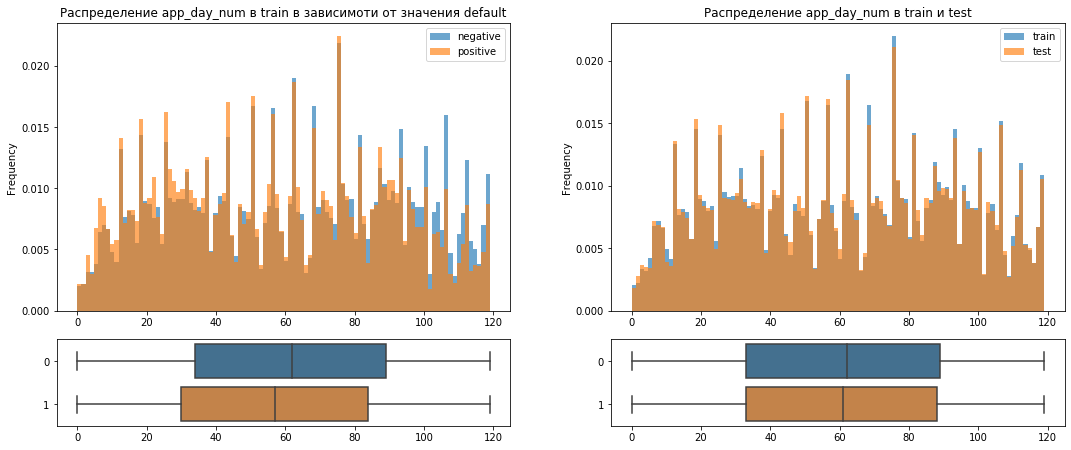

In [13]:
num_visualisation('app_day_num',data)

На графике распределений `app_day_num` в обучающей части выборки заметен сдвиг влево (в более ранний период) 'дефолтного распределения'. Т.е. со временем доля дефолтов падает. Обьяснения тому могут быть разные: банк настроил скоринговыу систему, или вышел в новый, более кредитоспособный сегмент рынка, или , например, более поздние клиенты еще не успели проявить себя во всей своей красе.  
На графике распределений `app_day_num` на обучающей и валидационной части выборки заметна совсем неболшая разница - медиана и 3 квартиль на валидационной части немного меньше. Разница небольшая, новсе же есть. Если такая картина повторится во многих признаках, то будет иметь смысл нормировать выборки совместно.

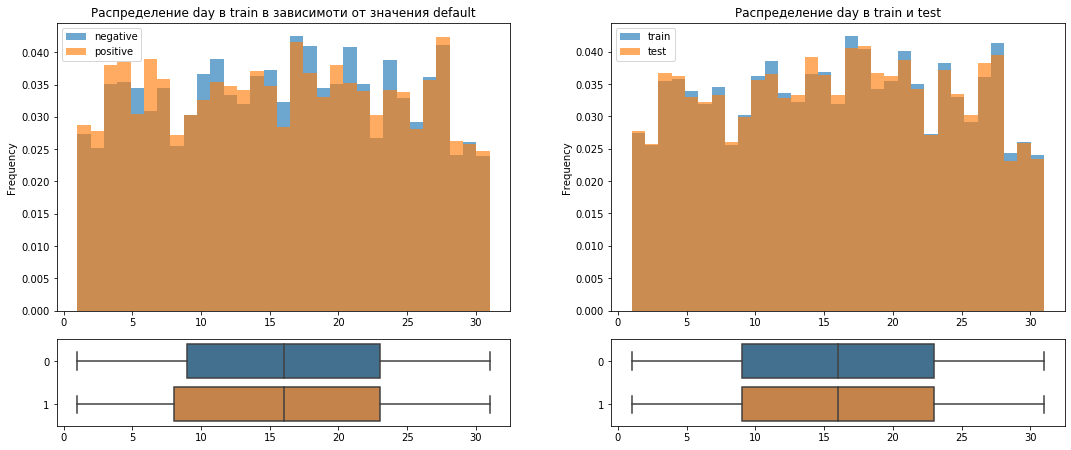

In [14]:
num_visualisation('day',data)

В этом признаке 'дефолтное' распределние немного сдвинуто влево. Т.е. дефолтные клиенты с немного большей вероятностью подают заявку на кредит в начале месяца, чем клиенты платежеспособныые.  
Разница в распределении признака в обучающей и валидационной части незаметна.

,0,1,2,3,4,5,6
neg,0.914436,0.914686,0.917013,0.912003,0.919338,0.911654,0.914148
pos,0.085564,0.085314,0.082987,0.087997,0.080662,0.088346,0.085852


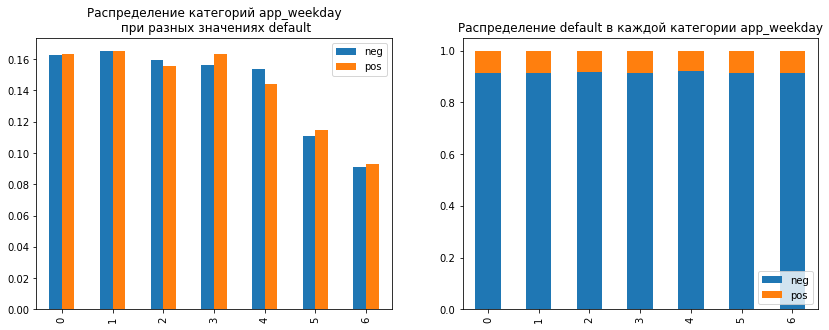

In [15]:
cat_visualisation(data[data['sample']==1].app_weekday)

Из распределения можно заметить, что у дефолтных клиетов четверг и выходные дни чуть более популярны чем у платежеспособных.

,0,1
neg,0.915456,0.912787
pos,0.084544,0.087213


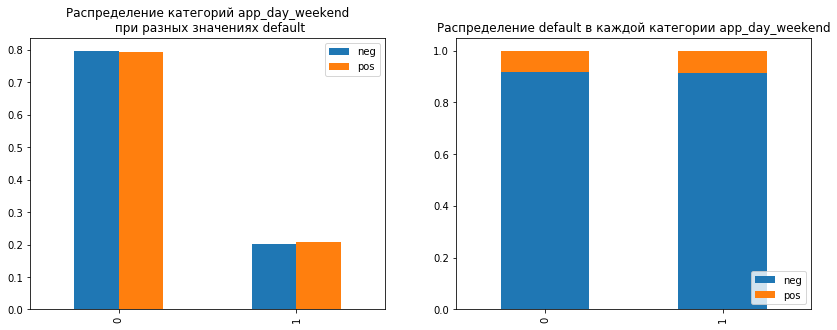

In [16]:
cat_visualisation(data[data['sample']==1].app_day_weekend)


Невооруженным глазом что либо интересное заметить ссложно. Разве что небольшое превышение в популярности выходных для подачи заявки среди дефолтных клиентов. Возможно в силу финансового неблагополучия они слишком заняты в будни подработками?

,0,1
neg,0.91635,0.909751
pos,0.08365,0.090249


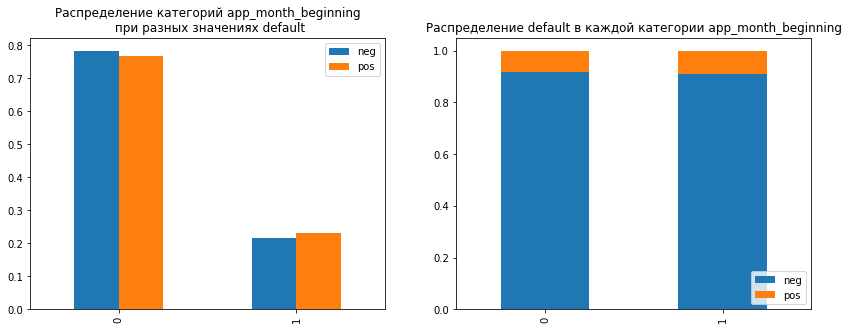

In [17]:
cat_visualisation(data[data['sample']==1].app_month_beginning)

Картина в целом такая же по смыслу как ии в признаке `day`. Дефолтные клиенты не сильно, но предпочитают подавать заявки в начале ммесяца. Будем надеяться, что специальный бинарный признак на эту тему поможет модели.

Дальнейшую предобработку(кодировку, нормировку и т.д.) вновь созданных из временного ряда признаков произведем одновременно со остальными признаками.

## Количественные признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности. Отмечу, что из рассмотрения не исключен казалось бы неинформативный признак `client_id` - поскольку признаков совсем немного, попробуем и из идентификатора извлечь информацию, а именно предположим что идентификатор отражает хронологический порядок занесения клиента в базу. Если такое предположение верно - признак окажется полезным при анализе, создании новых признаков и обучении модели.

Всего признаков этого типа 6. К ним относятся: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, income


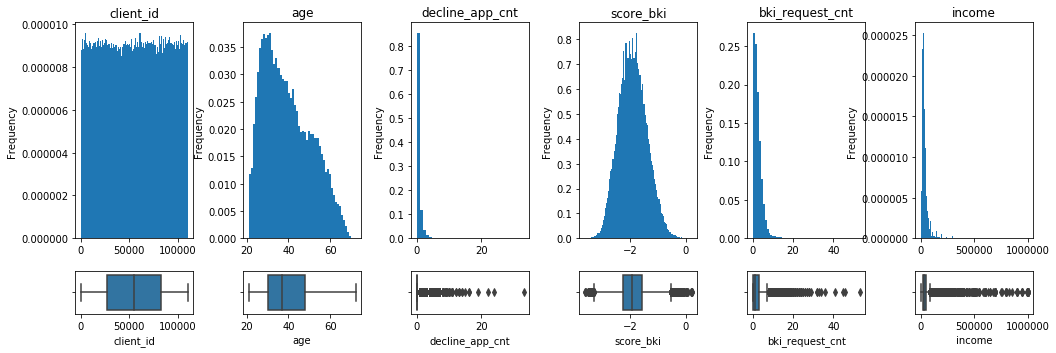

In [18]:
nums_visualisation(train[num_cols], annotation=True)

Как видим, кроме признаков `client_id` и `score_bki`  числовые признаки имеют сильно скошенное вправо распределение. Такая ассиметрия будет мешать линейной модели. Применим логарифмирование: 

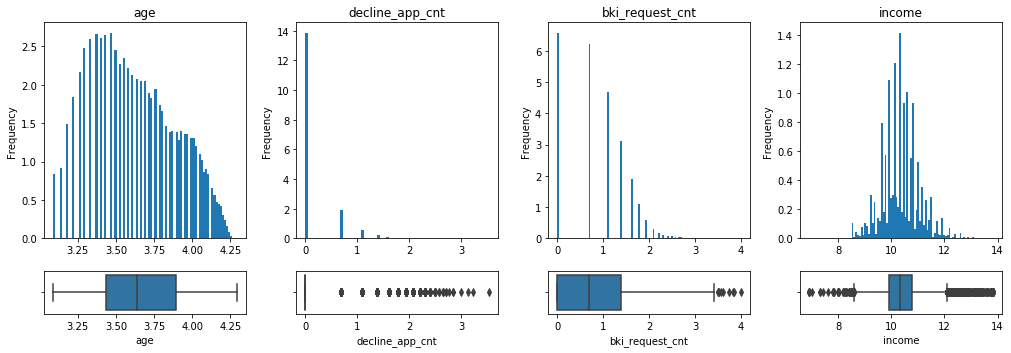

In [19]:
nums_visualisation(np.log(train[num_cols.drop(['client_id','score_bki'] )]+1))

Ситуация улучшилась: логарифмированные `age` и `income` рапсределены похоже на нормально, а в `decline_app_cnt` и `bki_request_cnt` скошенность, судя по boxplot-ам существенно уменьшилась.

Рассмотрим теперь количественные признаки по отдельности. Логарифмируемые признаки будем анализировать сразу с учетом преобразования.


### Age
Согласно описанию - возраст заемщика

Посмториим на распределения отдельно для позитивного и негативного класса целевоцй переменной. Так же поступим и с другими признаками

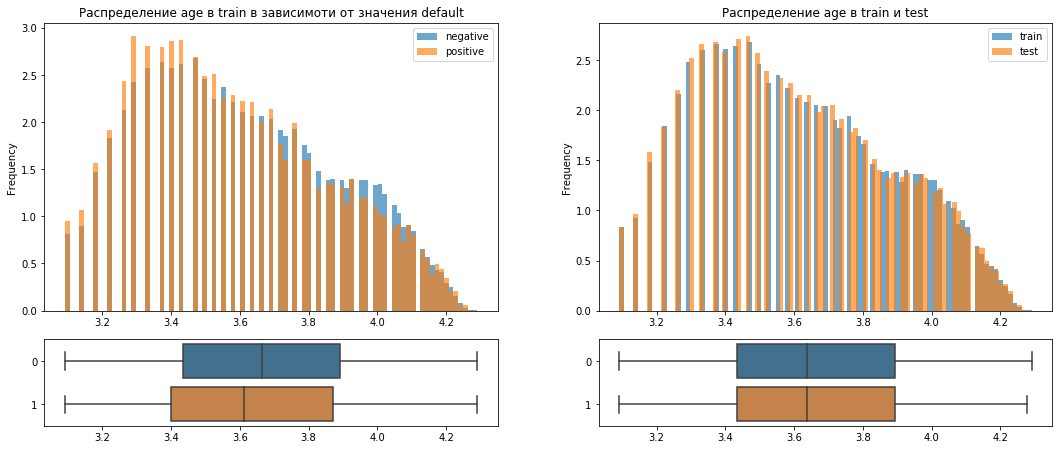

In [20]:
num_visualisation('age',data,lg=True)

Дефолтные клиенты в среднем попомоложе. Признак должен быть полезным. 
Разница в распределении признака в обучающей и валидационной части незаметна

### decline_app_cnt
Согласно описанию  - количество отказанных прошлых заявок

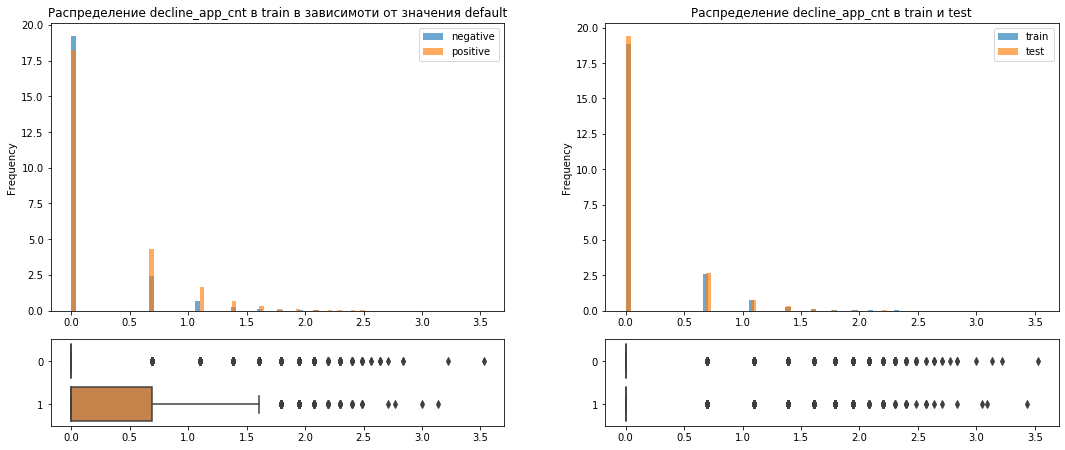

In [21]:
num_visualisation('decline_app_cnt',data,lg=True)

Ожидаемо количество отказов дефолтным клиентам выше чем платежеспсосбным. Остается не понятным - дефолтным стали чаще отказывать после допущеного неплатежа или и до него им выдавали кредиты менее охотно.

### score_bki
Согласно описанию - скоринговый балл по данным из БКИ

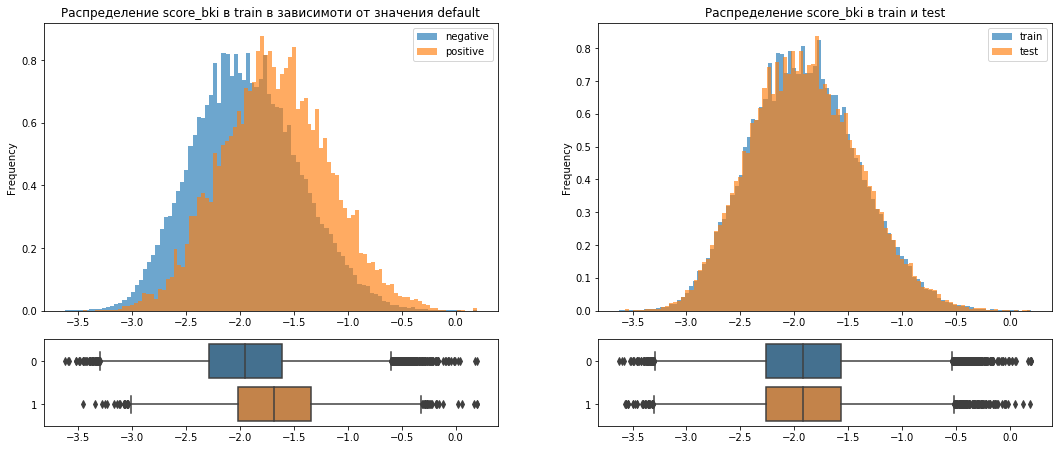

In [22]:
# num_visualisation(train.score_bki,train.default)
num_visualisation('score_bki',data)

Это видимо будет самы информационный признак. Сильная разница в распределениях дефолтных и платежеспопосбных.

Различия в распределении в обучающей и валидационной части не видно.

### bki_request_cnt
Согласно описанию - количество запросов в БКИ

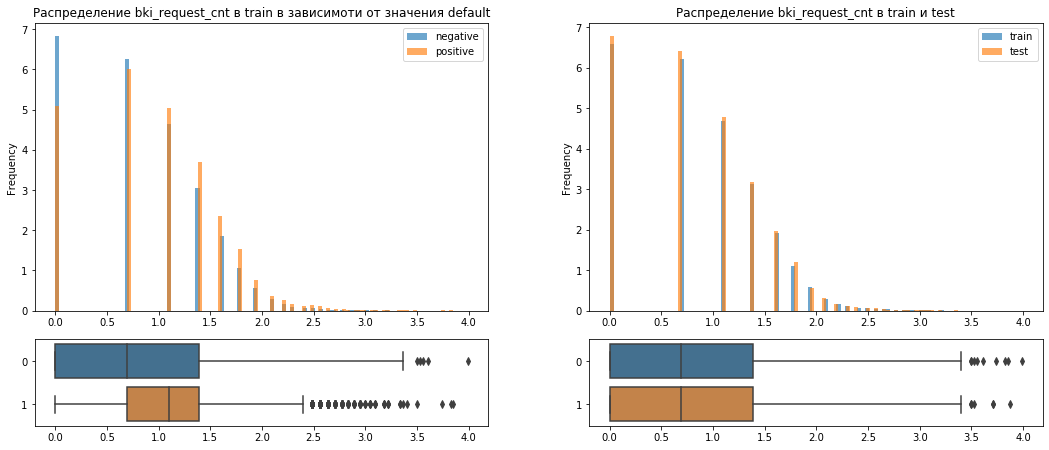

In [23]:
num_visualisation('bki_request_cnt',data,lg=True)

Как и в признаке `decline_app_cnt` распределение сильно похоже на распределение Пуассона, что в общем то не удивительно, поскольку признак имеет похожую природу.  
Как видно при сравнении распределений дефолтных и платежеспособных клиентов у дефолтных среднее количество запросов выше. Толи дефолтные клиенты сами часто итересуются свое КИ, толи они чаще пытаются получить кредит в финансовой организации или рассрочку платежа у продавца/поставщика услуги.Наверное имеет место и то и другое.  
Существенная разница в распределениях в обучающей и валидационной части отсутсвует.

### income
Согласно описанию - доход заемщика

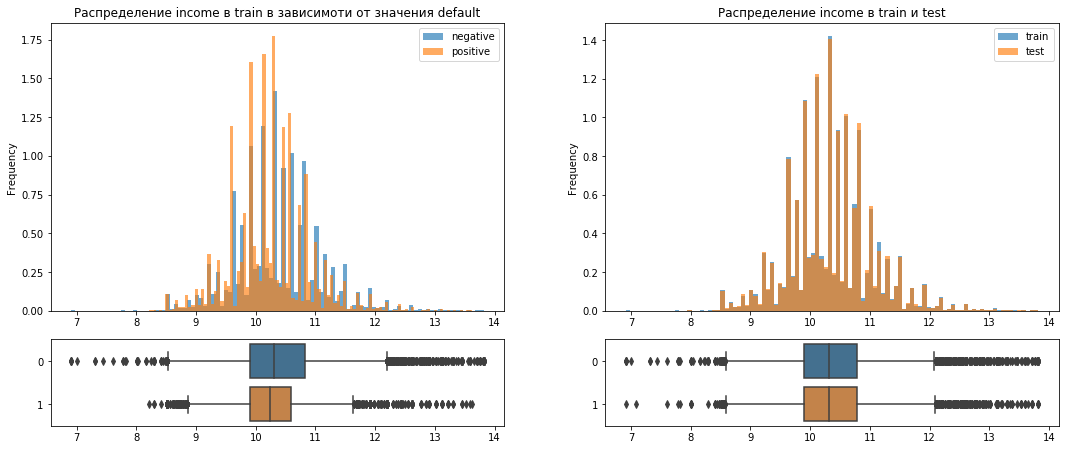

In [24]:
num_visualisation('income',data,lg=True)

Доходы дефолтных клиентов в среднем ниже, меньше и разброс их доходов. Парадоксально самые низкие доходы у платежеспособных. Возможно наименьшие доходы в выборке у тех кто реальные доходы просто не показывает? Или как вариант - клиентам с минимальными доходами просто не дают кредит, что гарантирует отсутсвие дефолта.  
Разница между обучающей и валидационной выборкой отсутсвует.

### client_id
Согласно описанию - идентификатор клиента

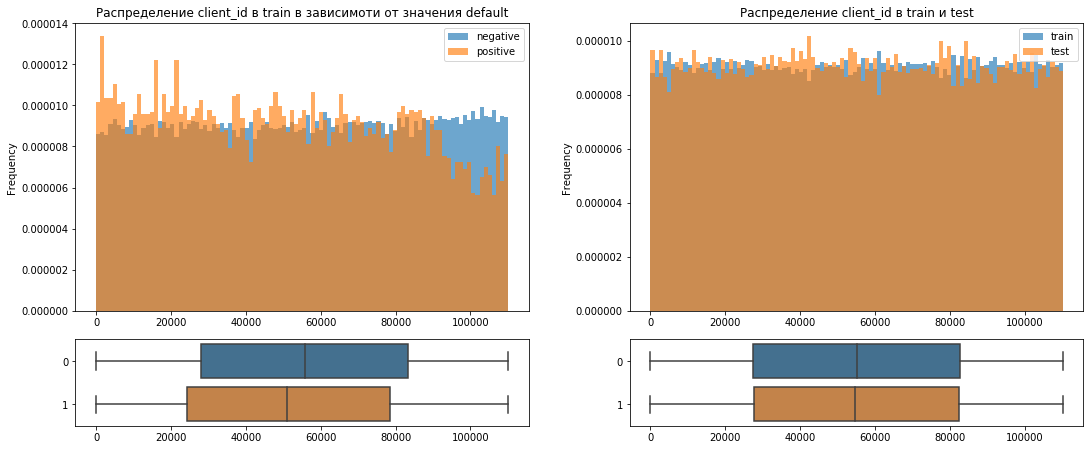

In [25]:
# num_visualisation(train.client_id,train.default)
num_visualisation('client_id',data)

Весьма любопытная картина. Можно заметить что распределения дефолтных и платежеспособных клиентов различаются.    

При малых значениях признака (т.е. при более раннем попадании в базу данных) плотность дефолтных выше, при наиболее высоких значениях (т.е. при более позднем попадании в базу) плотность дефолтных заметно снижается. В середине в распределении плато.  
Заметны три области с различным распределением: от 0 до 20 000, от 20 000 до 90 000 и от 90 0000.  

У платежеспсобных плотность едва приблизительно/округленно монотоно растет.

Возможные обьяснения такие же как и в признаке `app_day_num` - прогресс в качестве скоринга, выход в новые сегменты рынка и т.д.. Отмечу, что при очевидно высокой корреляции этих двух признаков, удаление одного из них понижает метрику на 1-2 тысячных, что  в нашей ситуации довольно много.

На основе сделанных при анализе `client_id` наблюдений будут созданы новые признаки.

## Категориальные признаки
Посмотрим на распределение по категориям в каждом признаке:

Всего признаков этого типа 6. К ним относятся: education, region_rating, home_address, work_address, sna, first_time


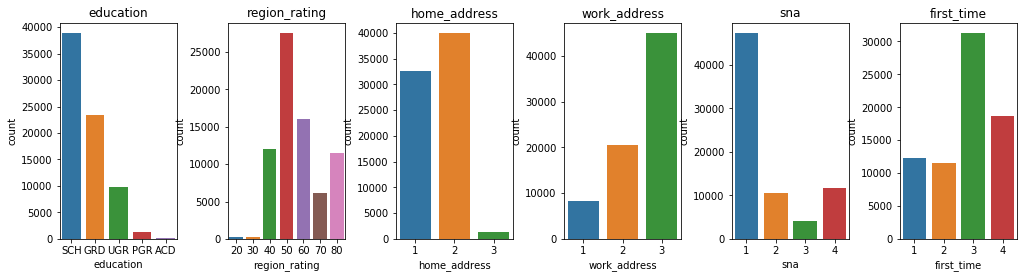

In [26]:
cats_visualisation(train[cat_cols]) 

Как видим распределение по категориям в признаках имеет несбалансированый характер. Возможно будет иметь смысл обьеденить миноритарные категории в одну.  
**UPD**: обьеденение видимого эффекта не показало.
  
Расссмотрим каждый признак отдельно:
### education
Согласно описанию - уровень образования

,SCH,GRD,UGR,PGR,ACD
neg,0.8991,0.939456,0.912463,0.956568,0.972509
pos,0.1009,0.060544,0.087537,0.043432,0.027491


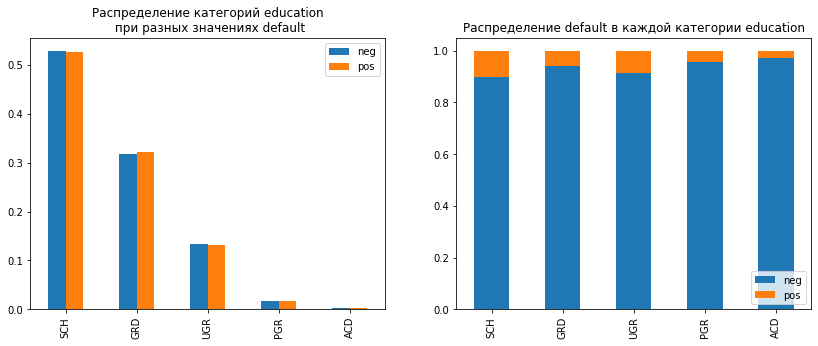

In [27]:
cat_visualisation(train.education)

Самые ненадежные заемщики - просто закончившие школу, далее по росту надежности следут получающие степень бакалавра, затем бакалавр, магистр и академик. Образование повышает финансовую дисциплину? Возможно.

### region_rating
Согласно описанию - рейтинг региона

,50,60,40,80,70,30,20
neg,0.908567,0.913705,0.886276,0.951136,0.938414,0.868664,0.859425
pos,0.091433,0.086295,0.113724,0.048864,0.061586,0.131336,0.140575


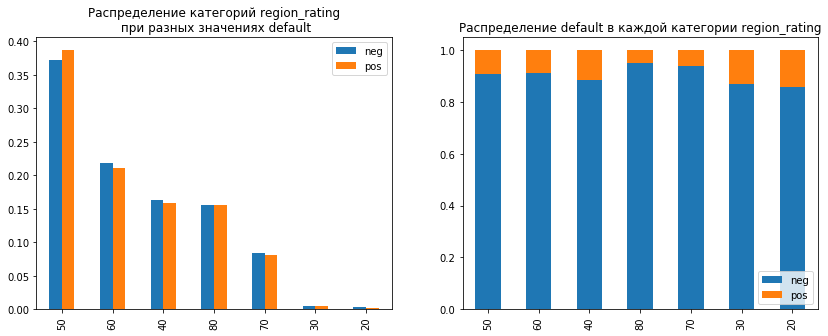

In [28]:
cat_visualisation(train.region_rating)

Рейтинг региона прямо коллерирует с надежностью замщика -  сростом рейтинга палаеь для дефолтных клиентов.

### home_address
Согласноописанию - категоризатор домашнего адреса

,2,1,3
neg,0.895974,0.937829,0.921883
pos,0.104026,0.062171,0.078117


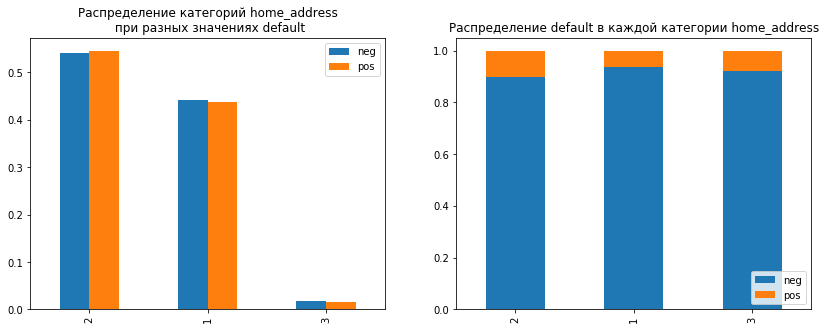

In [29]:
cat_visualisation(train.home_address)

Доминируют две категории - 1 и 2. В этих двух категориях разница в долях дефолтных клиентов небольшая, но есть. Признак наверное будет полезным

### work_address
Согласно описанию - категоризатор рабочего адреса

,3,2,1
neg,0.900884,0.931667,0.94965
pos,0.099116,0.068333,0.05035


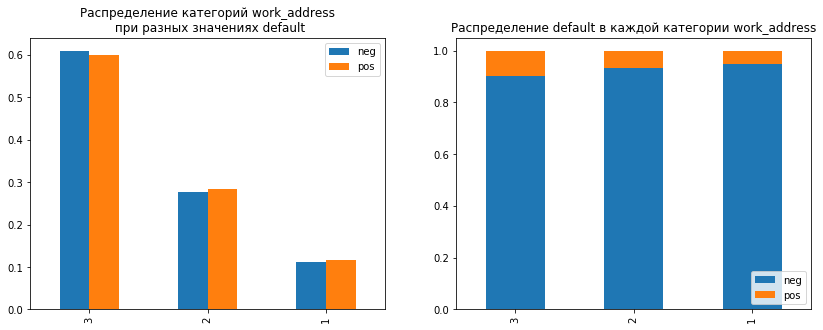

In [30]:
cat_visualisation(train.work_address)

Доля дефолтных клиенов в самой популярной категории 3 отличается от такой доли в других категориях. Признак наверное полезный

### sna 
Согласно описанию - связь заемщика с клиентами банка

,1,4,2,3
neg,0.934282,0.857846,0.899444,0.894378
pos,0.065718,0.142154,0.100556,0.105622


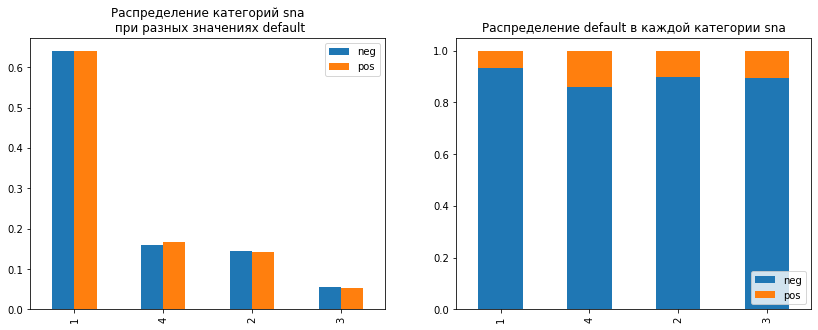

In [31]:
cat_visualisation(train.sna)

Есть категория с сильно отличающейся долей дефолтных клиентов. Признак должен быть полезным

### first_time
Согласно описанию - давность наличия информации о заемщике

,3,4,1,2
neg,0.919314,0.94514,0.875492,0.89575
pos,0.080686,0.05486,0.124508,0.10425


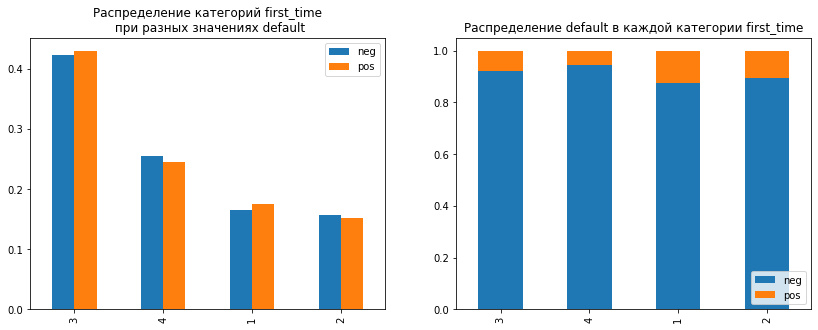

In [32]:
cat_visualisation(train.first_time)

Как  и уже встреченных признаках, имеющих временную природу, есть зависимость между давностью появления клиента в базе и долей дефолтных клиентов

## Бинарные признаки
Теперь рассмотрим бинарные признаки - ........

Всего признаков этого типа 6. К ним относятся: sex, car, car_type, good_work, foreign_passport, default


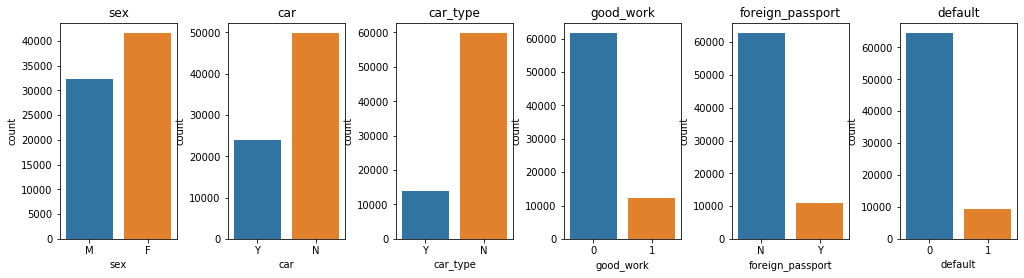

In [33]:
cats_visualisation(train[bin_cols]) 

### sex 
Согласно описанию - пол заемщика

,F,M
neg,0.91851,0.910312
pos,0.08149,0.089688


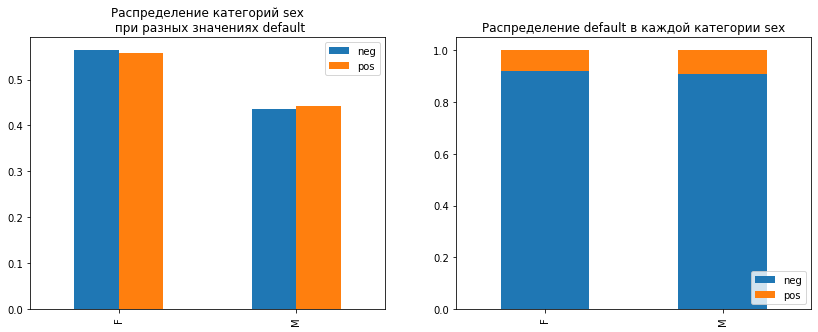

In [34]:
cat_visualisation(train.sex)

Женщины более дисциплинирванные заемщики. 

### car
Согласно описанию - флаг наличия автомобиля

,N,Y
neg,0.90813,0.92897
pos,0.09187,0.07103


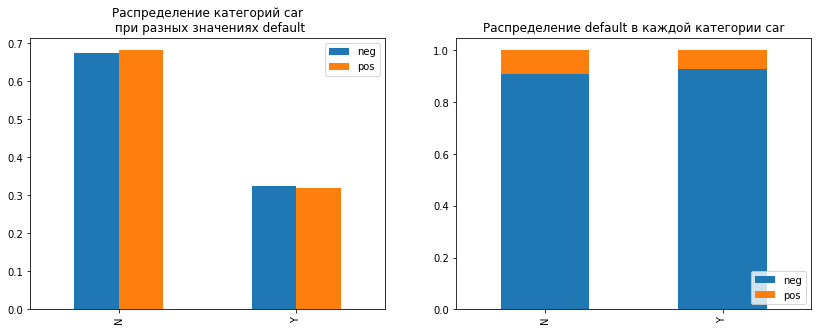

In [35]:
cat_visualisation(train.car)

In [ ]:
Люди с машиной видимо более основательны и финансво дисциплинированы.

### car_type
Согласно описанию - флаг автомобиля иномарки

,N,Y
neg,0.908604,0.941689
pos,0.091396,0.058311


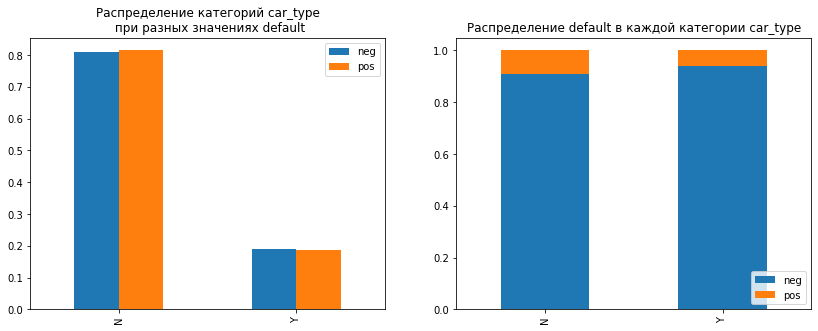

In [36]:
cat_visualisation(train.car_type)

Люди с иномаркой чуть-чуть менее хороши как заемщики, чем люди с прсто машиной. Тяга к роскоши портит?

### good_work
Согласно описанию - флаг наличия “хорошей” работы

,0,1
neg,0.91055,0.936921
pos,0.08945,0.063079


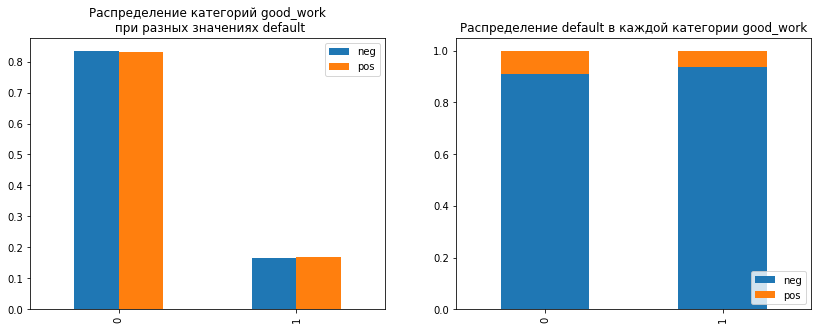

In [37]:
cat_visualisation(train.good_work)

Хорошая работа у клиента - удача не тлько для самого клиента, но и для его кредитора.

### foreign_passport
Согласно описанию  - наличие загранпаспорта

,N,Y
neg,0.90875,0.950082
pos,0.09125,0.049918


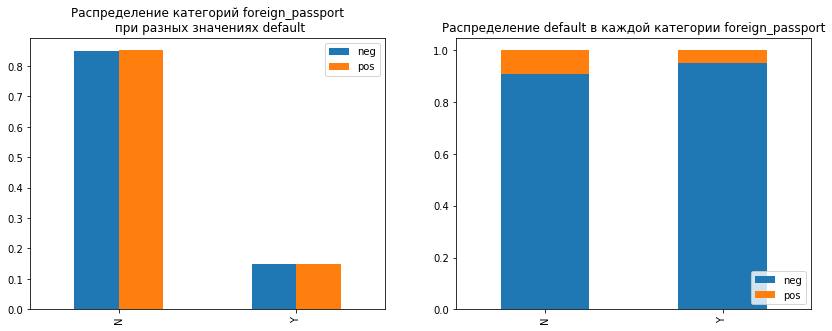

In [38]:
cat_visualisation(train.foreign_passport)

Клиент может позволить себе сьездить за рубеж или делает это по работе? Вероятно он погасит кредит -  то ли в силу неплохого финансового состояния, то ли из-за боязни сделаться невыездным.

# Первичная предобработка
Осуществим предобработку, согласно выбранным для каждого признака способам.

In [150]:
X = pre_process(data.drop(columns='default'))

# Baseline
Обучим на подготовленных данных модель LogisticRegression() спараметрами по умолчанию и получим значение метрики. Мы будем рассматривать эту модель как первую итерацию, первое приближение которое нужно улучшить.

In [151]:
X_train = X[X['sample']==1].drop(columns='sample')
y_train = train.default
validation(X_train, y_train, LogisticRegression())

0.7341966779195999

# Определение оптимального размера набора данных
В дальнейшем при отборе признаков, при подборе гиперпараметров нам предстоит многократное обучение модели на обучающей выборке. Для того чтобы оптимизировать процесс, проверим зависимость метрики от размера выборки, возможно что начиная с некоторого момента рост размера обучающей выборки перестает ощутимо влиять на качество модели и мы сможет произвести подбор гиперпараметров используя сокращенный/оптимизированный набор данных.

Получим при различных значениях взятой для обучения доли исходных данных значения метрики на тестовой выборке.

In [106]:
%%time
cv = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED)

_, _, test_scores = learning_curve(
       model, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 19), cv=cv, scoring = 'roc_auc')

Wall time: 29.3 s


Визуализируем полученный результат

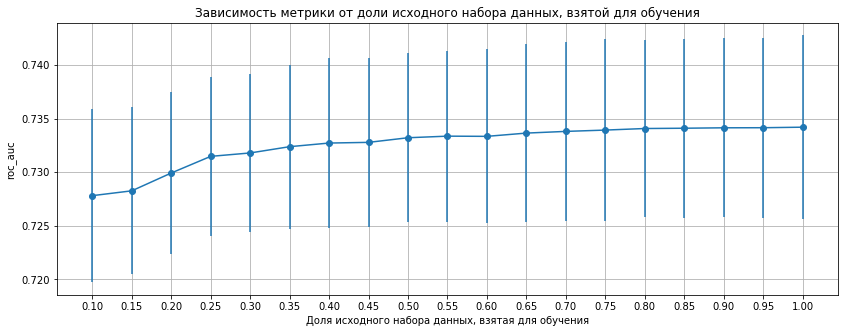

In [107]:
train_prop = np.linspace(.1, 1.0, 19)

test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(14,5))
plt.grid(True)
plt.xticks(train_prop)
plt.errorbar(train_prop, test_scores_mean , yerr = test_scores_std, fmt='o-')

plt.title('Зависимость метрики от доли исходного набора данных, взятой для обучения')
plt.ylabel('roc_auc')
plt.xlabel("Доля исходного набора данных, взятая для обучения");

Как видиим в рост постепенно затухает и призначениях 0.75 останавливается. Примем в качестве оптимального с точки зрения затрат времени размер данных в 0.75 от исходного количества

# Создание новых признаков

Сначала создадим признаки основываясь на предположениях о возможных зависимостях

In [108]:
# Бинарный признак не нулевого количества запросов в БКИ
data['bki_req_exist'] = (data.bki_request_cnt!=0).astype(int)

# Бинарный признак не нулевого количества отказов
data['decline_app_cnt_exist'] = (data.decline_app_cnt==0).astype(int)

# Бинарный признак нахождения клиента в одном из трех кластеров по времени оращения(по client_id)
data['claster_1'] = data.client_id.lt(10000).astype(int)
data['claster_2'] = data.client_id.between(10000,90000).astype(int)
data['claster_3'] = data.client_id.gt(90000).astype(int)

# Отношение количества запросов в БКИ ко времени внесения клиента в базу (как бы любопытность клиента)
data['pry'] = np.log(data.bki_request_cnt/data.client_id +1)

# Отношение количества отказов ко времени существоваия клиента в базе(как бы настойчивость)
data['persistence'] = np.log(data.decline_app_cnt/data.client_id +1)

# отношение отказов к возрасту (как бы ненадежность клиента)
data['unreliability'] = np.log(data.decline_app_cnt/data.age +1)

# отношение дохода к возрасту (успешность в доходах)
data['incom_career'] = np.log((data.income/data.age)+1)

# отношение ранга образования к возрасту (успешностьв образовании)
edu_dict = {'SCH': 1,'UGR': 2,'GRD': 3,'PGR': 4,'ACD': 5}
edu = data.education.fillna(data.education.mode()[0]).map(edu_dict)
data['edu_career'] = np.log((edu/data.age)+1)

# произведение 'крутости' клиента по машине, иномарке, загранпаспорту и хорошей работе
coolness_car = np.array([2 if x=='Y' else 1  for x in data.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
coolness_passport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['collness'] = coolness_car*coolness_import_car*coolness_passport*coolness_work

Проверим как изменилось качество предсказания моделью с параметрами по умолчанию на обогащенном наборе данных

In [109]:
%%time
# Просто осмысленные
X_enrich = pre_process(data.drop(columns='default'))
y_train = train.default

X_enrich_train = X_enrich[X_enrich['sample']==1].drop(columns='sample')

print(validation(X_enrich_train, y_train, LogisticRegression()))

0.7357657990554664
Wall time: 5.22 s


Качество улучшилось -  мы получили прирост метрики в несколько процентов за пару-тройку десятков строк простого кода. Для начала неплохо.   

Так же посмотрим на качество на оптимизированном по количеству наблюдений наборе

In [112]:
%%time
# Оптимизированные осмысленные
X_enrich_train_opt, _, y_train_opt, _ = train_test_split(
    X_enrich_train, y_train, train_size=0.75, stratify=y_train, random_state=RANDOM_SEED)            

print(validation(X_enrich_train_opt, y_train_opt, LogisticRegression()))

0.7351187842123098
Wall time: 3.71 s


Как видим качество немного просело по сравнению с полным набором (при метрика этом всё равно выше baselin-а). Будем считать это приемлемой платой за ускорение обучения в процессе отбора признаков и прдбора гиперпараметров, тем более, что окончательную модель обучим на полном наборе.

# Отбор признаков
Благодаря созданию новых признаков и их дальнейшей обработке в наборе уже несколько десятков признаков. Наверное уже имеет смысл попробовать отбросить те из них, что неполезны для модели - это вероятно улучшит качество и точно ускорит обучение.  

Прибегнем к отбору при помощи *Lasso* . Обучим эту модель на обогащенном по признакам и оптимизированном по количеству наблюдений наборе данных.

In [230]:
from sklearn.linear_model import Lasso

In [250]:
selector = Lasso(alpha=0.0001)
selector.fit(X_enrich_train_opt,y_train_opt)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Теперь получим список наименее полезных с точки зрения модели признков

In [252]:
sorted_by_Lasso = abs(pd.Series(selector.coef_,index = X_enrich_train.columns)).sort_values()
unuseful_features_LR = sorted_by_Lasso[sorted_by_Lasso<0.01].index

Не будем торопится(хоть время уже и поджимает) и вместо того, что бы просто удалить все неполезные признаки, станем удалять их по одному, начиная с  самого неполезного. И при этом будем следить за изменением метрики и остановимся на том количестве удаляемых признаков при котором изменение метрики будет наиболее выгодным.

In [254]:
model = LogisticRegression(random_state=RANDOM_SEED)
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features_LR),1)):
    to_drop = unuseful_features_LR[:loc] 
    X_tmp = X_enrich_train_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_train_opt,model)
    metrics_changes.loc[loc] = metrics_tmp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:41<00:00,  2.83s/it]


Посмотрим сколько пизнаков из unuseful_features_LR наиболее выгодно отбросить и какова метрика на наборе с отобранными таким образом признаками

In [255]:
print('Оптимально отбросить {} признаков, метрика при этом будет равна {}'.
      format(metrics_changes.idxmax(),  metrics_changes.max()))

Оптимально отбросить 30 признаков, метрика при этом будет равна 0.7359646174612733


Мы неплохо сократим обьем данных! И немного, но опять увеличим метрику. Кругом профит.

In [194]:
to_drop = unuseful_features_LR[:metrics_changes.idxmax()]
if 'sample' in to_drop: to_drop = to_drop.drop('sample',)
    
X_enrich_select = X_enrich.drop(columns=to_drop)
X_enrich_train_opt_select = X_enrich_train_opt.drop(columns=to_drop)

# Подбор гиперпараметров
Для подбора гиперпараметров будем использовать оптимальный по признакам и количесву наболюдений данных. Используем для поиска парметров, близких к оптимальным реализацию ***sklearn.model_selection.RandomizedSearchCV***. Этот подход позволяет обойтись меньшимим ресурсами, по сравнению с, например, ***GridSearchCV***.

In [152]:
%%time
n_iter = 75
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_enrich_train_opt_select, y_train_opt)

CPU times: user 39min 45s, sys: 8.35 s, total: 39min 53s
Wall time: 34min 29s


In [ ]:
Получим оптимальные из перебранных solver и прочие параметры модели. Так же посмотрим на метрику выбранной модели.

In [153]:
fin_solver = search.apply(lambda x: x.best_score_).idxmax()
fin_params = search[fin_solver].best_params_
fin_solver, search[fin_solver].best_score_, fin_params

('lbfgs',
 0.7360103680104956,
 {'penalty': 'l2', 'max_iter': 500, 'class_weight': {0: 1, 1: 4}, 'C': 0.1})

Метрика улучшилась. Хорошо.  
Определим окончательную модель.

In [154]:
fin_model = search[fin_solver].best_estimator_

In [ ]:
Проведем валидацию этой модели и убедимся в возросшем её качестве:

In [156]:
X_enrich_select_train = X_enrich_select[X_enrich_select['sample']==1].drop(columns='sample')
validation(X_enrich_select_train, y_train, fin_model)

0.7362221051913149

# Submission
Обучим модель на полной обучающей выборке (с учетом обогащения признаками и их последующим отбором)

In [157]:
fin_model.fit(X_enrich_select_train,y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 4}, max_iter=500)

Отделим от обьедененного датасета валидационную часть и получим на ней предсказание целевой переменной.

In [158]:
X_enrich_select_test = X_enrich_select[X_enrich_select['sample']==0].drop(columns='sample')

pred = fin_model.predict_proba(X_enrich_select_test)[:,1]

In [ ]:
Сформируем и отправим submission:

In [161]:
submission = pd.DataFrame(dict(client_id = test.client_id,default = pred))

submission.to_csv('submission_tmp.csv', index=False)

# ЗЫ:
Уф-ф. Кажется успел. Прошу прощения за ячепятки, недооформленый код и недописанные коментарии